Bienvenido al Análisis Económico con datos del Banco Mundial
Se analizarán PIB per cápita e Inflación de Colombia, México y Estados Unidos.
Ingresa año inicial, la base viene desde 1960 (ej:1963)): 1980
Ingrese año final, la base va hasta 2023(ej:2021)): 2021

Descargando datos de PIB per cápita...

--- PIB per cápita ---
    Año     Colombia       México  Estados Unidos
0  1980  1279.501167  3054.621623    12574.791506
1  1981  1362.183325  3829.144375    13976.105393
2  1982  1425.399368  2620.957934    14433.787727
3  1983  1383.792461  2169.852853    15543.893717
4  1984  1335.528218  2506.307428    17121.225485


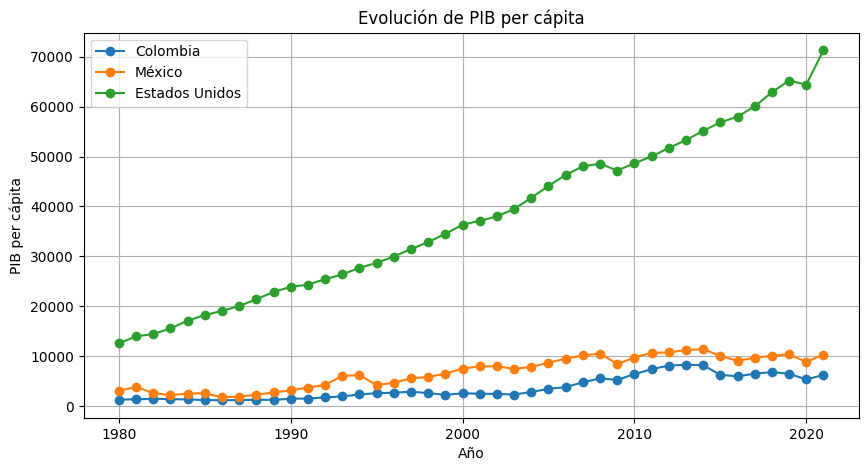


Estadísticas de PIB per cápita con Numpy:
 Colombia: promedio=3621.08, mediana=2594.67, máximo=8279.10, mínimo=1169.46
 México: promedio=6753.76, mediana=7479.05, máximo=11391.38, mínimo=1756.94
 Estados Unidos: promedio=37736.18, mediana=36731.80, máximo=71307.40, mínimo=12574.79

Descargando datos de Inflación...

--- Inflación ---
    Año   Colombia      México  Estados Unidos
0  1980  26.552653   26.351651       13.549202
1  1981  27.453762   27.933763       10.334715
2  1982  24.720988   58.913420        6.131427
3  1983  19.597317  101.874938        3.212435
4  1984  16.161617   65.448807        4.300535


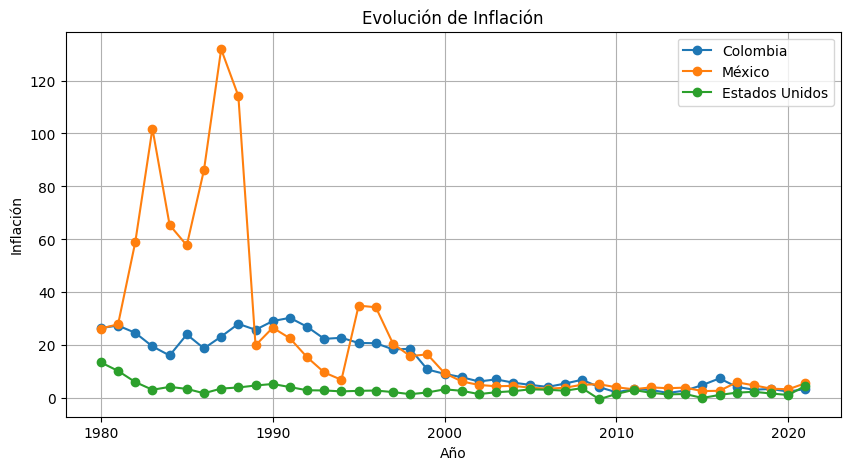


Estadísticas de Inflación con Numpy:
 Colombia: promedio=13.39, mediana=8.60, máximo=30.39, mínimo=2.02
 México: promedio=23.70, mediana=6.67, máximo=131.83, mínimo=2.72
 Estados Unidos: promedio=3.21, mediana=2.84, máximo=13.55, mínimo=-0.36


In [8]:


# PROGRAMA DE ANÁLISIS ECONÓMICO: PIB e Inflación de Colombia, México y USA durante 1960 al 2023
# Este programa descarga datos reales del Banco Mundial de PIB per cápita e Inflación
# Se conecta a la API oficial: http://api.worldbank.org

import requests                    # Librería que sirve para conectarse a la API del Banco Mundial y pedir datos
import pandas as pd                # Librería para manejar los datos en tablas (DataFrames)
import numpy as np                 # Librería para hacer cálculos numéricos y estadísticos rápidos
import matplotlib.pyplot as plt    # Para hacer gráficas bonitas

# Diccionario con los indicadores que vamos a consultar en el Banco Mundial
INDICADORES = {
    "PIB per cápita": "NY.GDP.PCAP.CD",   # Código del PIB per cápita (US$ corrientes)
    "Inflación": "FP.CPI.TOTL.ZG"         # Códido de la Inflación (%anual)
}

# Diccionario con los países (nombre -> código oficial del BM(API))
PAISES = {
    "Colombia": "COL",
    "México": "MEX",
    "Estados Unidos": "USA"
}

# Clase que organiza todo el análisis económico
class AnalisisEconomico:
    def __init__(self, paises, indicadores):
        """Cuando creo el objeto, guardo los países e indicadores que voy a usar."""
        self.paises = paises
        self.indicadores = indicadores

    def descargar_datos(self, pais, indicador, inicio, fin):
        """Función que descarga los datos de la API del Banco Mundial para un país e indicador."""

        codigo_pais = self.paises[pais]  # Saco el código oficial del país

        # Construyo la URL para pedir los datos al Banco Mundial (país, indicador y rango de años)
        url = f"http://api.worldbank.org/v2/country/{codigo_pais}/indicator/{indicador}?date={inicio}:{fin}&format=json&per_page=1000"

        # Le pido la info al servidor
        respuesta = requests.get(url)

        datos_json = respuesta.json()      # Paso la respuesta a formato JSON

        # Si el JSON está vacío o no hay datos, devuelvo tabla vacía
        if len(datos_json) < 2 or not datos_json[1]:
            print(f"No se encontraron datos para {pais}.")
            return pd.DataFrame()

        # LIST COMPREHENSION: aquí limpio los datos y creo lista de diccionarios con año y valor (si no es nulo)
        registros = [
            {"Año": int(item["date"]), pais: item["value"]}
            for item in datos_json[1] if item["value"] != None]


        # Convierto la lista de registros en un DataFrame ordenado por año
        df = pd.DataFrame(registros).sort_values("Año").reset_index(drop=True)
        return df

    def combinar_datos(self, indicador, inicio, fin):
        """Combina los datos de varios países en un solo DataFrame (tabla grande)."""

        dfs = []  # Lista vacía para ir guardando cada DataFrame
        for pais in self.paises:  # Recorro cada país y descargo sus datos
            df = self.descargar_datos(pais, indicador, inicio, fin)
            if not df.empty: #Si no está vacío
                dfs.append(df)

        # Si sí hay datos, los uno en un solo DataFrame
        if dfs:
            df_final = dfs[0]
            for df in dfs[1:]:
                df_final = pd.merge(df_final, df, on="Año", how="outer")
            return df_final.sort_values("Año").reset_index(drop=True)
        else:
            return pd.DataFrame() #Si no hay datos devuelve vacio

    def generar_grafico(self, df, variable):
        """Hace un gráfico de la evolución en el tiempo para cada país."""

        plt.figure(figsize=(10, 5))  # Tamaño del gráfico
        for pais in self.paises:     # Pinto cada país
            if pais in df.columns:   # Si el pais tiene datos
                plt.plot(df["Año"], df[pais], marker="o", linestyle="-", label=pais)

        plt.title(f"Evolución de {variable}")  # Título del gráfico
        plt.xlabel("Año")                      # Eje X
        plt.ylabel(variable)                   # Eje Y
        plt.legend()                           # Muestra nombres de paises
        plt.show()                             # Muestro la gráfica

    def estadisticas_numpy(self, df, variable):
        """Saca estadísticas básicas con Numpy y las imprime."""

        print(f"\nEstadísticas de {variable} con Numpy:")

        for pais in self.paises:
            if pais in df.columns:
                valores = np.array(df[pais].dropna())  # Paso los datos a Numpy

                if valores.size > 0:  # Solo si hay datos
                    promedio = np.mean(valores)     # Promedio
                    mediana = np.median(valores)    # Mediana
                    maximo = np.max(valores)        # Valor máximo
                    minimo = np.min(valores)        # Valor mínimo

                    print(f" {pais}: promedio={promedio:.2f}, mediana={mediana:.2f}, "
                          f"máximo={maximo:.2f}, mínimo={minimo:.2f}")


def pide_anos():
    """Función que pide al usuario los años inicial y final y valida la entrada."""
    while True:
        try:
            inicio = int(input("Ingresa año inicial, la base viene desde 1960 (ej:1963)): "))  # Pregunta inicio
            fin = int(input("Ingrese año final, la base va hasta 2023(ej:2021)): "))       # Pregunta fin
            if inicio < 1960 or fin > 2023:                       # Valido límites
                print("Rango fuera de límites. Use entre 1960 y 2023.")
            elif inicio > fin:                                    # Valido coherencia
                print("El año inicial no puede ser mayor que el final.")
            else:
                return inicio, fin
        except ValueError:  # Si meten texto y no número, avisa
            print("Por favor ingresa números válidos.")


def main():
    """Función principal que organiza todo el flujo del programa."""

    print("Bienvenido al Análisis Económico con datos del Banco Mundial")
    print("Se analizarán PIB per cápita e Inflación de Colombia, México y Estados Unidos.")

    inicio, fin = pide_anos()  # Pido al usuario el rango de los años

    # Creo un objeto de mi clase AnalisisEconomico (aquí uso la receta)
    analisis = AnalisisEconomico(PAISES, INDICADORES)

    # Recorro cada indicador (PIB, Inflación)
    for variable, indicador in INDICADORES.items():
        print(f"\nDescargando datos de {variable}...")
        df = analisis.combinar_datos(indicador, inicio, fin)

        if not df.empty:
            print(f"\n--- {variable} ---")
            print(df.head())  # Muestro primeras filas del DataFrame

            # Genero gráfico
            analisis.generar_grafico(df, variable)

            # Saco estadísticas con NumPy
            analisis.estadisticas_numpy(df, variable)


# Esto se asegura de que el programa arranque solo si lo ejecutamos directo
if __name__ == "__main__":
    main() # Lama a la función principal cuando se ejecuta el programa